In [1]:
import torch
import os

DATASET_PATH = os.path.join("datasets", "train")
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")
TEST_SPLIT = 0.15
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

In [2]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 64
# define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [3]:
# import the necessary packages
from torch.utils.data import Dataset
import cv2
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)

In [4]:
# import the necessary packages
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

c:\Users\Interaction Lab\anaconda3\envs\vision\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [5]:
# import the necessary packages
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [6]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

class UNet(Module):
    def __init__(self, encChannels=(3, 16, 32, 64),
        decChannels=(64, 32, 16),
        nbClasses=1, retainDim=True,
        outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
  
    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0],
            encFeatures[::-1][1:])
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        # return the segmentation map
        return map

In [7]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
	test_size=TEST_SPLIT, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()



[INFO] saving testing image paths...


In [8]:
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((INPUT_IMAGE_HEIGHT,
		INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=0)
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=0)

[INFO] found 3400 examples in the training set...
[INFO] found 600 examples in the test set...


In [25]:
trainDS[0][0].shape

torch.Size([3, 128, 128])

In [9]:
# initialize our UNet model
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [12]:
import numpy as np

def compute_accuracy(prediction, label):
    
    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)

    prediction_binary   = (prediction >= 0.5).cpu().numpy()
    label               = label.bool().cpu().numpy()
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

In [13]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainAcc = 0.0
	totalTestAcc = 0.0
 
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
  
		totalTrainAcc += compute_accuracy(pred, y)  
  
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
			totalTestAcc += compute_accuracy(pred, y)   
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
 
	avgTrainAcc = totalTrainAcc / trainSteps
	avgTestAcc = totalTestAcc / testSteps 
 
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
 
	print("Train Acc: {:.6f}, Test Acc: {:.4f}".format(
		avgTrainAcc, avgTestAcc))
  	
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  2%|▎         | 1/40 [00:04<03:05,  4.75s/it]

[INFO] EPOCH: 1/40
Train loss: 0.411690, Test loss: 0.4019
Train Acc: 17.073606, Test Acc: 21.2903


  5%|▌         | 2/40 [00:09<02:54,  4.58s/it]

[INFO] EPOCH: 2/40
Train loss: 0.396742, Test loss: 0.3985
Train Acc: 18.525452, Test Acc: 22.8015


  8%|▊         | 3/40 [00:13<02:49,  4.58s/it]

[INFO] EPOCH: 3/40
Train loss: 0.386626, Test loss: 0.4543
Train Acc: 19.372772, Test Acc: 16.4825


 10%|█         | 4/40 [00:18<02:43,  4.55s/it]

[INFO] EPOCH: 4/40
Train loss: 0.383184, Test loss: 0.3941
Train Acc: 18.699226, Test Acc: 21.6471


 12%|█▎        | 5/40 [00:22<02:38,  4.52s/it]

[INFO] EPOCH: 5/40
Train loss: 0.377060, Test loss: 0.3850
Train Acc: 18.939399, Test Acc: 21.9795


 15%|█▌        | 6/40 [00:27<02:33,  4.50s/it]

[INFO] EPOCH: 6/40
Train loss: 0.364422, Test loss: 0.4044
Train Acc: 20.363743, Test Acc: 19.8306


 18%|█▊        | 7/40 [00:31<02:28,  4.50s/it]

[INFO] EPOCH: 7/40
Train loss: 0.367311, Test loss: 0.3857
Train Acc: 20.044125, Test Acc: 17.4773


 20%|██        | 8/40 [00:36<02:24,  4.51s/it]

[INFO] EPOCH: 8/40
Train loss: 0.358848, Test loss: 0.3633
Train Acc: 20.200574, Test Acc: 24.8458


 22%|██▎       | 9/40 [00:40<02:19,  4.49s/it]

[INFO] EPOCH: 9/40
Train loss: 0.343437, Test loss: 0.3749
Train Acc: 20.951222, Test Acc: 26.6158


 25%|██▌       | 10/40 [00:45<02:14,  4.49s/it]

[INFO] EPOCH: 10/40
Train loss: 0.358153, Test loss: 0.4217
Train Acc: 20.346428, Test Acc: 14.0532


 28%|██▊       | 11/40 [00:49<02:10,  4.50s/it]

[INFO] EPOCH: 11/40
Train loss: 0.350331, Test loss: 0.3634
Train Acc: 20.929251, Test Acc: 20.3875


 30%|███       | 12/40 [00:54<02:05,  4.49s/it]

[INFO] EPOCH: 12/40
Train loss: 0.332052, Test loss: 0.4118
Train Acc: 21.292757, Test Acc: 16.2587


 32%|███▎      | 13/40 [00:58<02:00,  4.48s/it]

[INFO] EPOCH: 13/40
Train loss: 0.354141, Test loss: 0.3734
Train Acc: 20.570875, Test Acc: 25.8192


 35%|███▌      | 14/40 [01:03<01:56,  4.46s/it]

[INFO] EPOCH: 14/40
Train loss: 0.345468, Test loss: 0.3534
Train Acc: 22.258661, Test Acc: 23.3096


 38%|███▊      | 15/40 [01:07<01:51,  4.48s/it]

[INFO] EPOCH: 15/40
Train loss: 0.340810, Test loss: 0.3489
Train Acc: 21.149498, Test Acc: 21.7602


 40%|████      | 16/40 [01:11<01:47,  4.47s/it]

[INFO] EPOCH: 16/40
Train loss: 0.327828, Test loss: 0.3397
Train Acc: 21.125986, Test Acc: 23.1369


 42%|████▎     | 17/40 [01:16<01:42,  4.46s/it]

[INFO] EPOCH: 17/40
Train loss: 0.316513, Test loss: 0.3294
Train Acc: 22.817462, Test Acc: 23.8853


 45%|████▌     | 18/40 [01:20<01:38,  4.47s/it]

[INFO] EPOCH: 18/40
Train loss: 0.316376, Test loss: 0.3107
Train Acc: 22.690990, Test Acc: 26.2492


 48%|████▊     | 19/40 [01:25<01:33,  4.47s/it]

[INFO] EPOCH: 19/40
Train loss: 0.311349, Test loss: 0.3127
Train Acc: 22.386496, Test Acc: 24.6421


 50%|█████     | 20/40 [01:29<01:29,  4.47s/it]

[INFO] EPOCH: 20/40
Train loss: 0.308376, Test loss: 0.3147
Train Acc: 22.435678, Test Acc: 23.4441


 52%|█████▎    | 21/40 [01:34<01:25,  4.49s/it]

[INFO] EPOCH: 21/40
Train loss: 0.318723, Test loss: 0.4375
Train Acc: 22.259803, Test Acc: 16.6734


 55%|█████▌    | 22/40 [01:38<01:20,  4.47s/it]

[INFO] EPOCH: 22/40
Train loss: 0.345854, Test loss: 0.3496
Train Acc: 21.206684, Test Acc: 22.9504


 57%|█████▊    | 23/40 [01:43<01:15,  4.47s/it]

[INFO] EPOCH: 23/40
Train loss: 0.327247, Test loss: 0.3495
Train Acc: 22.645650, Test Acc: 25.2629


 60%|██████    | 24/40 [01:47<01:11,  4.44s/it]

[INFO] EPOCH: 24/40
Train loss: 0.320037, Test loss: 0.3465
Train Acc: 22.867553, Test Acc: 22.9473


 62%|██████▎   | 25/40 [01:52<01:06,  4.45s/it]

[INFO] EPOCH: 25/40
Train loss: 0.316361, Test loss: 0.3317
Train Acc: 23.330738, Test Acc: 26.6230


 65%|██████▌   | 26/40 [01:56<01:02,  4.49s/it]

[INFO] EPOCH: 26/40
Train loss: 0.313072, Test loss: 0.3376
Train Acc: 23.836439, Test Acc: 28.7165


 68%|██████▊   | 27/40 [02:01<00:59,  4.56s/it]

[INFO] EPOCH: 27/40
Train loss: 0.311367, Test loss: 0.3217
Train Acc: 22.661593, Test Acc: 25.3273


 70%|███████   | 28/40 [02:06<00:55,  4.59s/it]

[INFO] EPOCH: 28/40
Train loss: 0.308314, Test loss: 0.3413
Train Acc: 23.354601, Test Acc: 26.1394


 72%|███████▎  | 29/40 [02:10<00:50,  4.58s/it]

[INFO] EPOCH: 29/40
Train loss: 0.297358, Test loss: 0.2993
Train Acc: 23.437490, Test Acc: 26.5363


 75%|███████▌  | 30/40 [02:15<00:45,  4.53s/it]

[INFO] EPOCH: 30/40
Train loss: 0.289450, Test loss: 0.3016
Train Acc: 23.280395, Test Acc: 27.8553


 78%|███████▊  | 31/40 [02:19<00:40,  4.49s/it]

[INFO] EPOCH: 31/40
Train loss: 0.277234, Test loss: 0.2963
Train Acc: 24.112964, Test Acc: 25.2452


 80%|████████  | 32/40 [02:23<00:35,  4.50s/it]

[INFO] EPOCH: 32/40
Train loss: 0.275691, Test loss: 0.2950
Train Acc: 24.407895, Test Acc: 28.5679


 82%|████████▎ | 33/40 [02:28<00:31,  4.50s/it]

[INFO] EPOCH: 33/40
Train loss: 0.296963, Test loss: 0.2916
Train Acc: 23.225110, Test Acc: 25.9114


 85%|████████▌ | 34/40 [02:32<00:26,  4.48s/it]

[INFO] EPOCH: 34/40
Train loss: 0.272943, Test loss: 0.2874
Train Acc: 24.619038, Test Acc: 25.6061


 88%|████████▊ | 35/40 [02:37<00:22,  4.46s/it]

[INFO] EPOCH: 35/40
Train loss: 0.276932, Test loss: 0.3057
Train Acc: 24.595661, Test Acc: 29.3343


 90%|█████████ | 36/40 [02:41<00:17,  4.48s/it]

[INFO] EPOCH: 36/40
Train loss: 0.279126, Test loss: 0.2871
Train Acc: 24.200217, Test Acc: 25.4683


 92%|█████████▎| 37/40 [02:46<00:13,  4.47s/it]

[INFO] EPOCH: 37/40
Train loss: 0.270011, Test loss: 0.2833
Train Acc: 24.664513, Test Acc: 26.3458


 95%|█████████▌| 38/40 [02:50<00:08,  4.46s/it]

[INFO] EPOCH: 38/40
Train loss: 0.272472, Test loss: 0.2891
Train Acc: 24.631251, Test Acc: 28.1251


 98%|█████████▊| 39/40 [02:55<00:04,  4.46s/it]

[INFO] EPOCH: 39/40
Train loss: 0.266699, Test loss: 0.2838
Train Acc: 24.541163, Test Acc: 28.0818


100%|██████████| 40/40 [02:59<00:00,  4.49s/it]

[INFO] EPOCH: 40/40
Train loss: 0.261420, Test loss: 0.2960
Train Acc: 25.403146, Test Acc: 25.5854
[INFO] total time taken to train the model: 179.65s


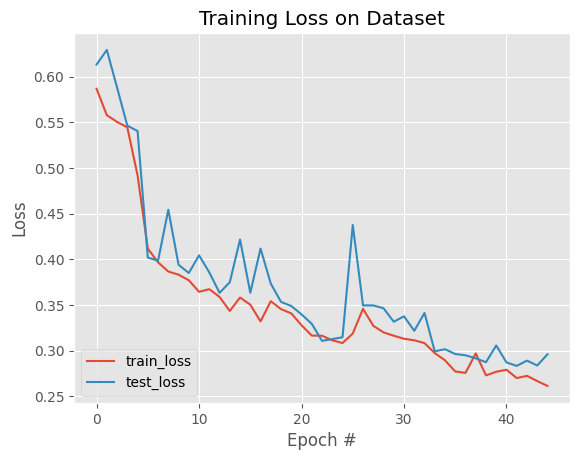

In [14]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)

In [16]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [18]:
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(MASK_DATASET_PATH,
			filename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT,
			INPUT_IMAGE_HEIGHT))
  
		# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
		# filter out the weak predictions and convert them to integers
		predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)
		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

[INFO] loading up test image paths...
[INFO] load up model...


c:\Users\Interaction Lab\anaconda3\envs\vision\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


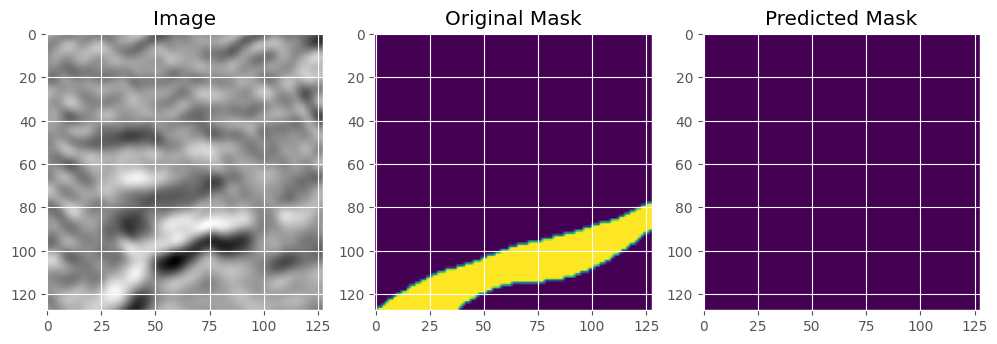

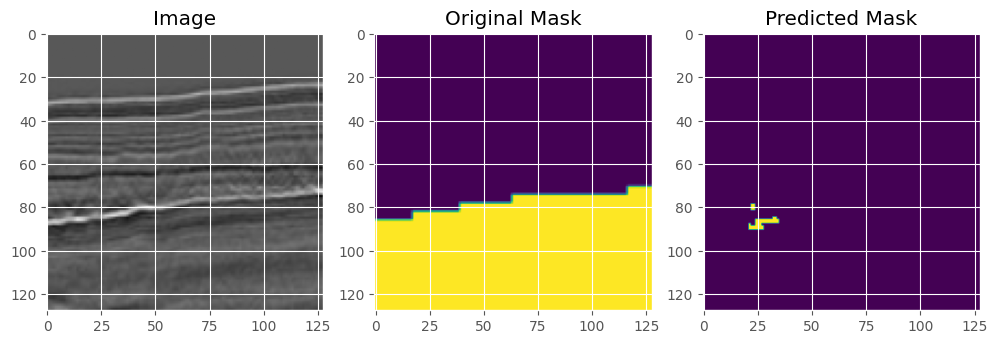

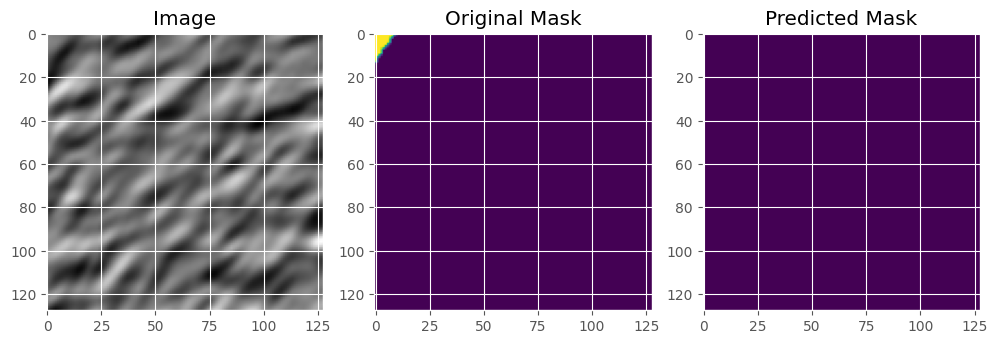

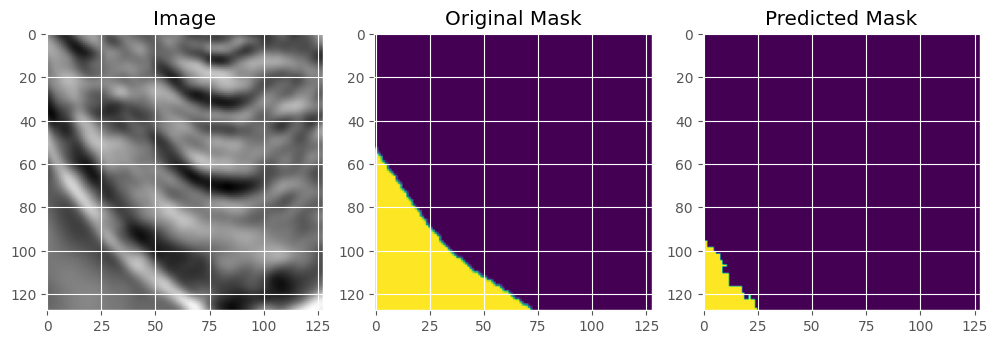

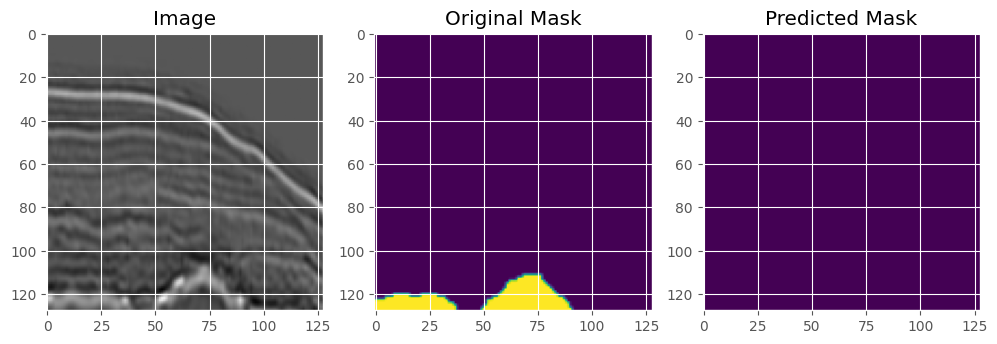

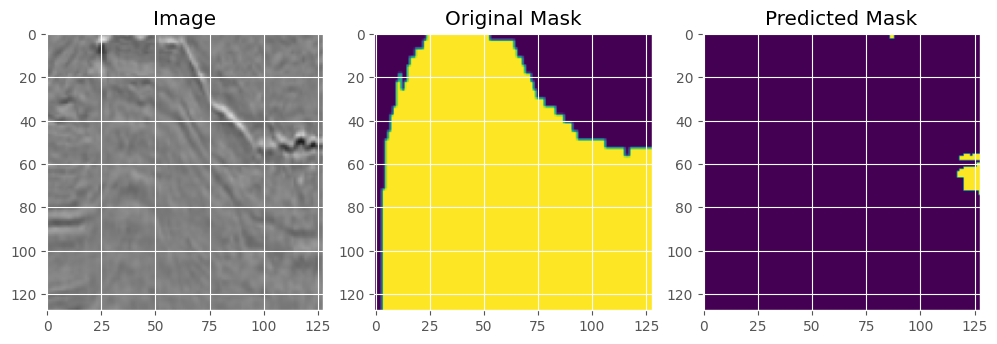

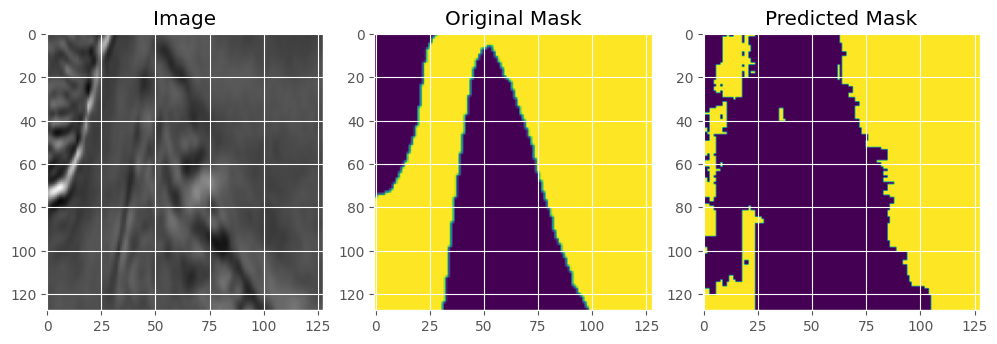

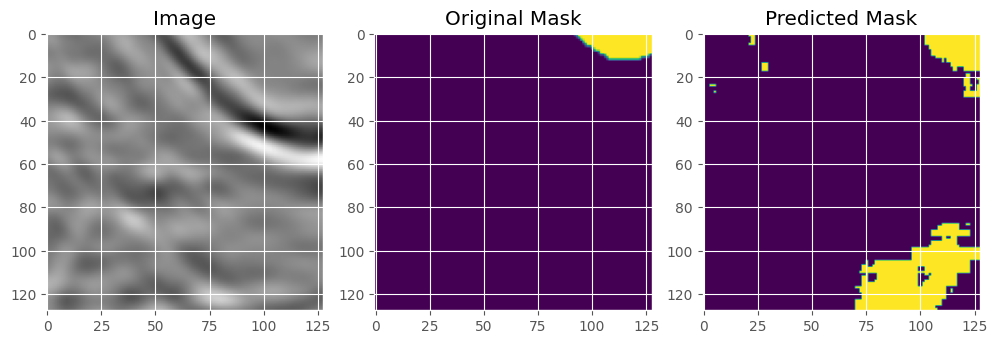

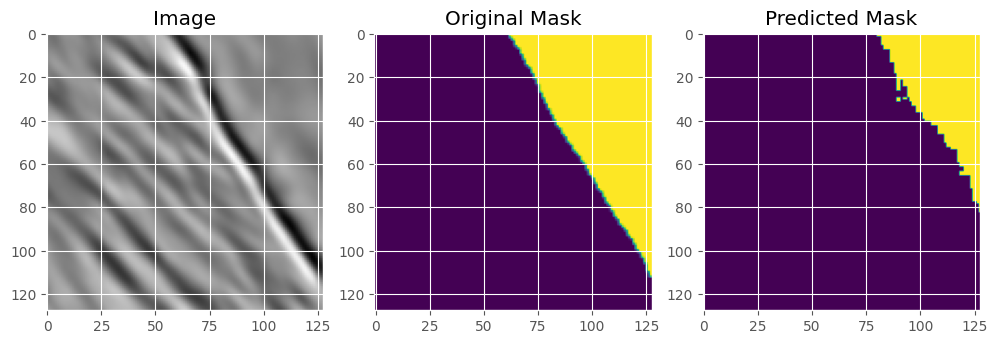

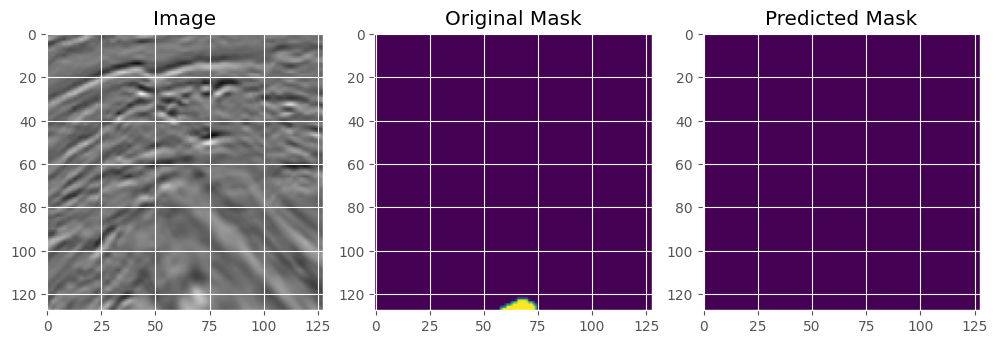

In [23]:
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path)